In [138]:
import pandas as pd
import spacy
import steamreviews
import json
import csv
import os
import glob
import json
import matplotlib.pyplot as plt
import nltk
import wordcloud
from wordcloud import WordCloud
import re
import plotly
import seaborn as sns
import stanza

from pandas.io.json import json_normalize
from nltk.corpus import stopwords
from tqdm.notebook import trange, tqdm

## Reviews download
https://pypi.org/project/steamreviews/

In [139]:
dir_name = "data"
reviews_jsons = glob.glob(f"{dir_name}/*")
reviews_jsons

['data\\review_1150690.json',
 'data\\review_1172620.json',
 'data\\review_1341290.json',
 'data\\review_1515210.json',
 'data\\review_210970.json',
 'data\\review_219150.json',
 'data\\review_219890.json',
 'data\\review_250320.json',
 'data\\review_257510.json',
 'data\\review_262060.json',
 'data\\review_289070.json',
 'data\\review_294100.json',
 'data\\review_304430.json',
 'data\\review_394360.json',
 'data\\review_400.json',
 'data\\review_427520.json',
 'data\\review_460950.json',
 'data\\review_550.json',
 'data\\review_620.json',
 'data\\review_632470.json',
 'data\\review_646570.json',
 'data\\review_736260.json',
 'data\\review_860510.json']

In [140]:
title_dict = {"219150": "Hotline Miami",
              "1172620" : "Sea of Thieves",
              "460950" : "Katana ZERO",
              "262060" : "Darkest Dungeon",
              "250320" : "The Wolf Among Us",
              "210970" : "The Witness",
              "620" : "Portal 2",
              "736260" : "Baba Is You",
              "219890" : "Antichamber",
              "289070" : "Sid Meier's Civilization VI",
              "427520" : "Factorio",
              "257510" : "The Talos Principle",
             "304430" : "INSIDE",
             "400" : "Portal",
             "394360" : "Hearts of Iron IV",
             "632470" : "Disco Elysium",
             "294100" : "RimWorld",
              "646570" : "Slay the Spire",
              "1150690" : "Omori",
              "1341290" : "We Were Here Forever",
              "1515210" : "The Past Within",
              "860510" : "Little Nightmares II",
              "550" : "Left 4 Dead 2"}

In [141]:
genre_dict = {"219150": "A",
              "1172620" : "A",
              "460950" : "A",
              "262060" : "R",
              "250320" : "R",
              "210970" : "P",
              "620" : "P",
              "736260" : "P",
              "219890" : "P",
              "289070" : "S",
              "427520" : "S",
              "257510" : "P",
              "304430" : "P",
             "400" : "P",
             "394360" : "S",
             "632470" : "R",
             "294100" : "S",
             "646570" : "R",
             "1150690" : "R",
             "1341290" : "P",
             "1515210" : "P",
             "860510" : "P",
             "550" : "A"}

In [142]:
data_list = []
for i in reviews_jsons:
    with open(i, encoding = "utf-8") as json_file:
        json_data = json.load(json_file)
        reviews = json_data['reviews']
        file_name = json_file.name.split('.')[0].split('_')[1]
        for key in reviews.keys():
            data_list.append([title_dict.get(file_name),genre_dict.get(file_name),reviews[key]['author']['steamid'], reviews[key]['votes_up'], 
                          reviews[key]['review'], reviews[key]['weighted_vote_score'], reviews[key]['voted_up'],
                          reviews[key]['author']['num_games_owned'], reviews[key]['author']['playtime_at_review'],
                          reviews[key]['author']['num_reviews'], 
                          reviews[key]["timestamp_created"] ])
df = pd.DataFrame(data_list, columns = ["title", "genre","steamid", "votes_up", "review", "weighted_vote_score", "voted_up",
                                        "num_games_owned", "playtime_at_review", "num_reviews", "timestamp_created"])

In [143]:
df.sample(frac=0.3).head()

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
30193,Disco Elysium,R,76561198108395190,1,The only time ive ever wanted to READ more whi...,0.5,True,508,1410,21,1667116043
27133,Portal 2,P,76561198072635147,1,Im in Spaaaaceeeee,0.523809552192687988,True,0,529,3,1669649019
28552,Disco Elysium,R,76561198010830163,6,"My god, is this game phenomenal. The writing i...",0.538703739643096924,False,215,2092,4,1694789562
10829,Sid Meier's Civilization VI,S,76561198991969706,1,"This game is SO complex, so baffling and so di...",0.523809552192687988,False,0,644,1,1669377427
16466,Hearts of Iron IV,S,76561198986984742,1,love it I haven't touched grass for years than...,0.523809552192687988,True,0,61545,4,1666809074


In [144]:
df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')

## Preprocessing

1. Braki danych
2. Usunięcie duplikatów
4. Usunięcie recenzjii krótszych niż 3 słowa
9. Usunięcie znaków spcjalnych 
10. "Text lowering"
6. Usunięcie znaków interpunkcyjnych i liczb
8. Usunięcie tytułów gier z recenzji
7. Tokenizacja
8. Part-of-speech tagging
9. Lematyzacja

#### Braki danych

In [145]:
df.isna().sum()

title                  0
genre                  0
steamid                0
votes_up               0
review                 0
weighted_vote_score    0
voted_up               0
num_games_owned        0
playtime_at_review     0
num_reviews            0
timestamp_created      0
dtype: int64

#### Usunięcie duplikatów

In [146]:
df.duplicated(subset='review').sum()

2580

In [147]:
df[df.duplicated(subset='review')].sample(20)

,title,genre,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created
16810,Hearts of Iron IV,S,76561199005827155,1,i hate myself,0.519999980926513672,True,0,3634,15,2023-05-22 20:41:24
23505,Left 4 Dead 2,A,76561198107779127,1,Good Game,0.523809552192687988,True,493,589,381,2023-03-04 16:07:10
20163,Factorio,S,76561198409212418,1,the factory must grow,0.523809552192687988,True,167,6375,3,2023-01-18 17:59:44
9904,Sid Meier's Civilization VI,S,76561198032460381,52,fun game,0.783392906188964844,True,0,1907704,1,2023-09-01 02:25:12
13360,RimWorld,S,76561197969862577,1,,0.523809552192687988,True,0,7941,5,2022-11-15 22:23:25
25789,Portal 2,P,76561199368047801,166,"Here I will leave the cat, friends who pass by...",0.760915875434875488,True,287,36767,183,2023-05-21 18:45:28
25614,Left 4 Dead 2,A,76561198360635400,900,why waste your money on back 4 blood when you ...,0.972714900970458984,True,0,1492,8,2022-01-02 22:16:49
30801,Slay the Spire,R,76561198069177088,1,Very fun,0.523809552192687988,True,0,5851,6,2022-10-25 01:00:47
24782,Left 4 Dead 2,A,76561199020827146,2,⣿⣿⣿⣿⣿⣿⣿⣿⠟⠋⠁⠀⠀⠀⠀⠀⠀⠀⠀⠉⠻⣿\n⣿⣿⣿⣿⣿⣿⣿⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢺...,0.52173912525177002,True,0,107,4,2023-03-20 20:02:23
26249,Portal 2,P,76561198926230141,1,k,0.523809552192687988,True,54,1630,7,2023-08-02 14:20:50


In [148]:
(df.duplicated(subset='review') == False).sum()

29492

In [149]:
df = df[df.duplicated(subset='review') == False]

In [150]:
df.duplicated(subset='review').sum()

0

#### Długość recenzji

In [151]:
df["temp_review_len"] = df["review"].apply(lambda x: x.split(" ").__len__())
df["temp_review_len"].describe()

count    29492.000000
mean        54.191984
std        135.354534
min          1.000000
25%          5.000000
50%         13.000000
75%         39.000000
max       3997.000000
Name: temp_review_len, dtype: float64

In [152]:
df[df["temp_review_len"] < 4].groupby(by=["genre"]).count()

,title,steamid,votes_up,review,weighted_vote_score,voted_up,num_games_owned,playtime_at_review,num_reviews,timestamp_created,temp_review_len
genre,,,,,,,,,,,
A,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659,1659
P,852,852,852,852,852,852,852,852,852,852,852
R,798,798,798,798,798,798,798,798,798,798,798
S,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140,1140


In [153]:
df = df[df["temp_review_len"] >= 3]

In [154]:
suma = 0
for i in df["temp_review_len"]:
    suma += i

In [155]:
print("Ilość słów:", suma,
     "Ilość recenzji:", len(df["temp_review_len"]))

Ilość słów: 1593992 Ilość recenzji: 26663


In [156]:
df = df.drop(["temp_review_len"], axis=1)

### Wordcloud

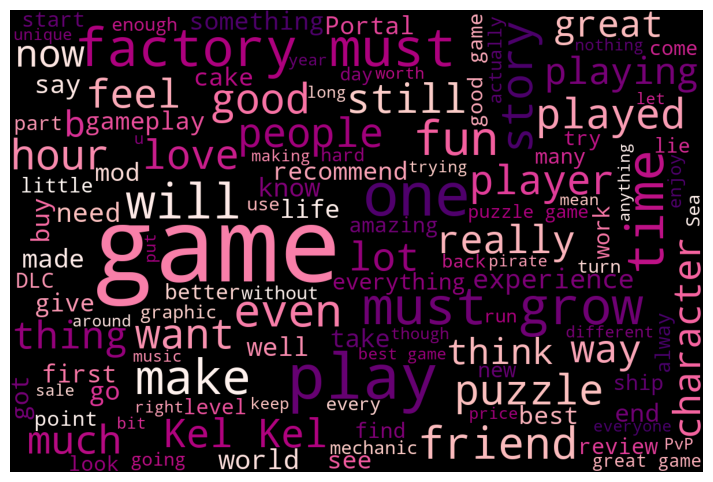

In [157]:
txt = ' '.join(i for i in df["review"])
wordcloud = WordCloud(max_font_size = 180,
                max_words = 120,
                width = 1200,
                height = 800,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

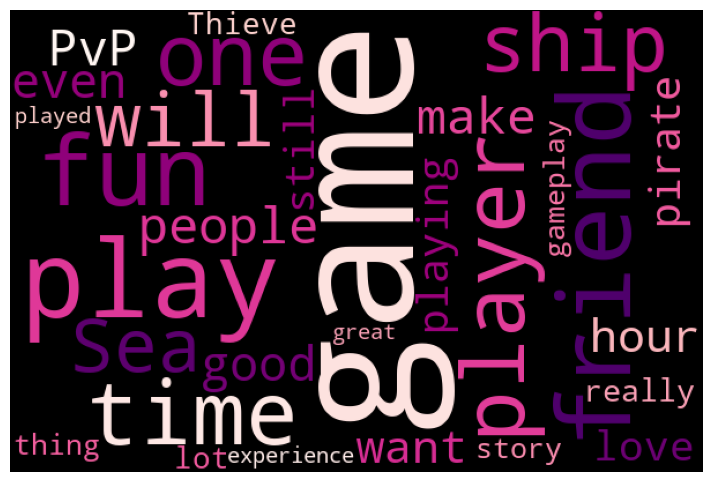

In [158]:
txt = ' '.join(i for i in df[df['genre'] == "A"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

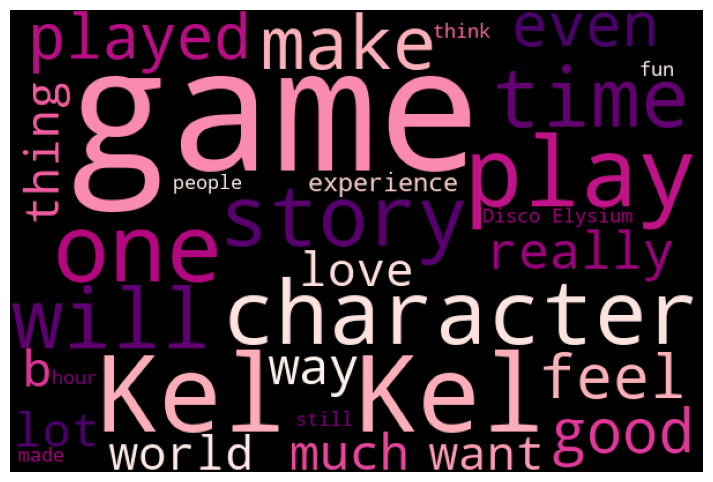

In [159]:
txt = ' '.join(i for i in df[df['genre'] == "R"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

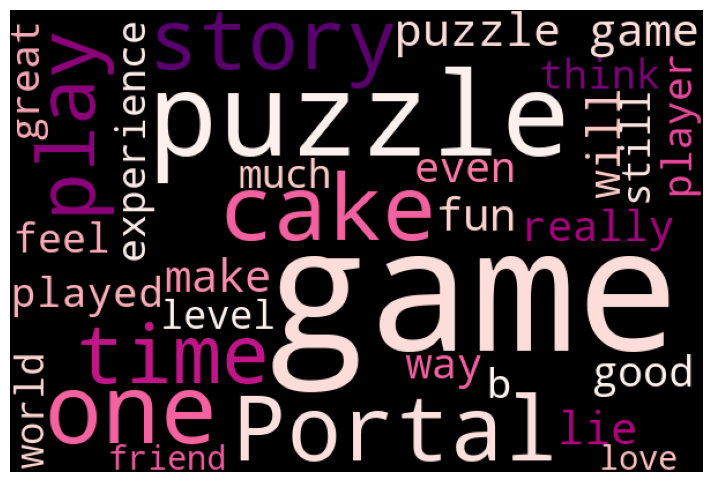

In [160]:
txt = ' '.join(i for i in df[df['genre'] == "P"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

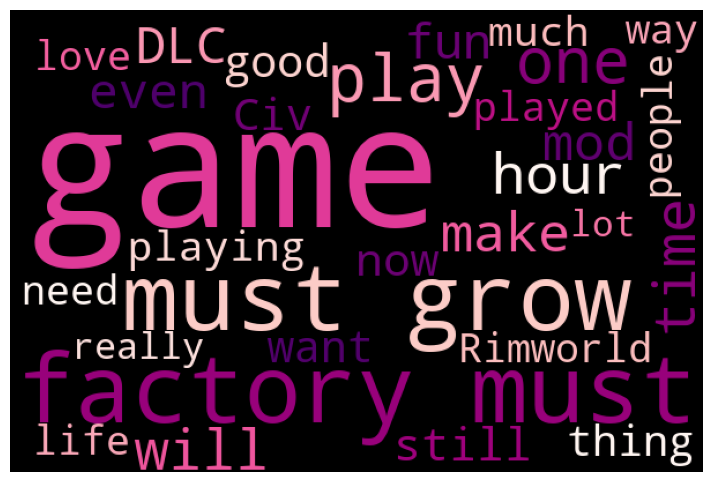

In [161]:
txt = ' '.join(i for i in df[df['genre'] == "S"]['review'])
wordcloud = WordCloud(max_font_size = 150,
                max_words = 30,
                width = 600,
                height = 400,
                background_color = "black",
                colormap='RdPu_r').generate(txt)

plt.figure(figsize=(12,6))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

#### Usunięcie znaków, text lowering

In [162]:
df["review"] = df["review"].str.replace(r"\[.*?\]|\n|[^\x00-\x7F]+", "", regex=True).str.lower()

In [163]:
df["review"].sample(10)

16073                        funy mustache man go brrrrrrr
12468    this game is stupid......stupid, good. maybe t...
31447                it's really good and i can't beat it.
12121    ---{ graphics }--- you forget what reality is ...
28282    i love this game. i love the brilliant writing...
20583                   i put 10 eaten conveyors out of 10
20960                             more addictive than drug
25263                                         i like coach
17786                   still have no idea what i'm doing.
15998                             sleepy joe esports micro
Name: review, dtype: object

#### Usunięcie znaków interpunkcyjnych i liczb

In [164]:
df["review"] = df["review"].str.replace(r"[0-9]", "", regex=True)

In [165]:
import string 
df["review"] = df["review"].str.replace('['  + string.punctuation + ']', "", regex =True)

In [166]:
df["review"].sample(5)

8770                               average croteam enjoyer
28402    a deeply flawed game that i desperately wanted...
5456                       weder richtig looten noch leven
5895     this is a warning to all reaper emmisary ships...
857      one of the cures for depressionanxietyif youre...
Name: review, dtype: object

#### Usunięcie tytułów gier z recenzji

In [167]:
for value in title_dict.values():
    df["review"] = df["review"].str.replace(value.lower(), "")

#### Tokenizacja

In [168]:
import nltk
df["tokenized"] = df["review"].apply(nltk.word_tokenize)

In [169]:
df["tokenized"].sample(15)

14403    [one, day, i, played, the, tutorial, for, this...
13037    [i, allied, a, rough, outlander, tribe, by, gi...
29479                       [kim, is, such, a, meow, meow]
19040    [its, been, years, and, this, game, is, still,...
2042     [this, game, gave, me, the, big, sad, would, a...
30238    [the, final, cutpanic, at, the, discofor, once...
16253                        [finally, figured, out, navy]
14054    [war, crime, and, catgirls, everything, a, gro...
16063             [i, like, the, hitler, rap, battle, mod]
10905    [i, got, the, game, and, a, ton, a, dlc, for, ...
28183    [never, got, around, to, finishing, this, game...
9709     [not, unusual, for, there, to, be, solid, minu...
419                         [i, fckuing, love, this, game]
27520         [the, little, turret, made, my, heart, melt]
16856                       [theres, nothing, we, can, do]
Name: tokenized, dtype: object

### Stopwords

In [170]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')
english_stopwords_cleaned = [word.replace("'", "") for word in english_stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marty\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [171]:
new_column = []
for row in df["tokenized"]:
    new_row = [word for word in row if word[0] not in english_stopwords_cleaned]
    new_column.append(new_row)
df["final_review"] = new_column

## Describe

In [172]:
df.dtypes

title                          object
genre                          object
steamid                        object
votes_up                        int64
review                         object
weighted_vote_score            object
voted_up                         bool
num_games_owned                 int64
playtime_at_review              int64
num_reviews                     int64
timestamp_created      datetime64[ns]
tokenized                      object
final_review                   object
dtype: object

In [173]:
df["weighted_vote_score"] = pd.to_numeric(df["weighted_vote_score"])

In [174]:
df["voted_up"] = pd.to_numeric(df["voted_up"])

In [175]:
df.describe()

,votes_up,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews
count,26663.000000,26663.000000,26663.000000,2.666300e+04,26663.000000
mean,31.715148,0.570098,140.866707,1.309372e+04,21.467689
std,173.097223,0.109932,538.652824,4.720263e+04,59.809381
min,0.000000,0.500000,0.000000,5.000000e+00,1.000000
25%,1.000000,0.521739,0.000000,5.350000e+02,3.000000
50%,1.000000,0.523810,0.000000,1.800000e+03,8.000000
75%,3.000000,0.545180,113.000000,7.111500e+03,20.000000
max,9568.000000,0.987843,22780.000000,1.890626e+06,3419.000000


C:\Users\marty\AppData\Local\Temp\ipykernel_15080\2159658958.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


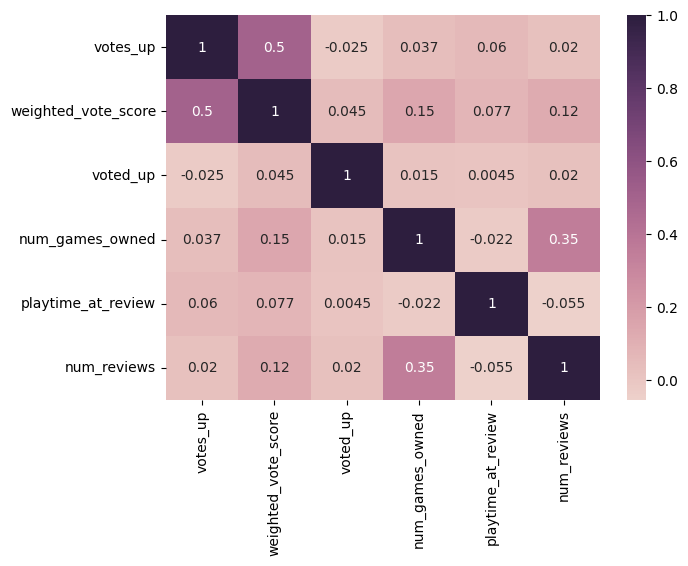

In [176]:
corr = df.corr()
plt.figure(figsize=(7,5))
sns.heatmap(corr, cmap=sns.cubehelix_palette(as_cmap=True),annot=True)
plt.show()

## Wykresy

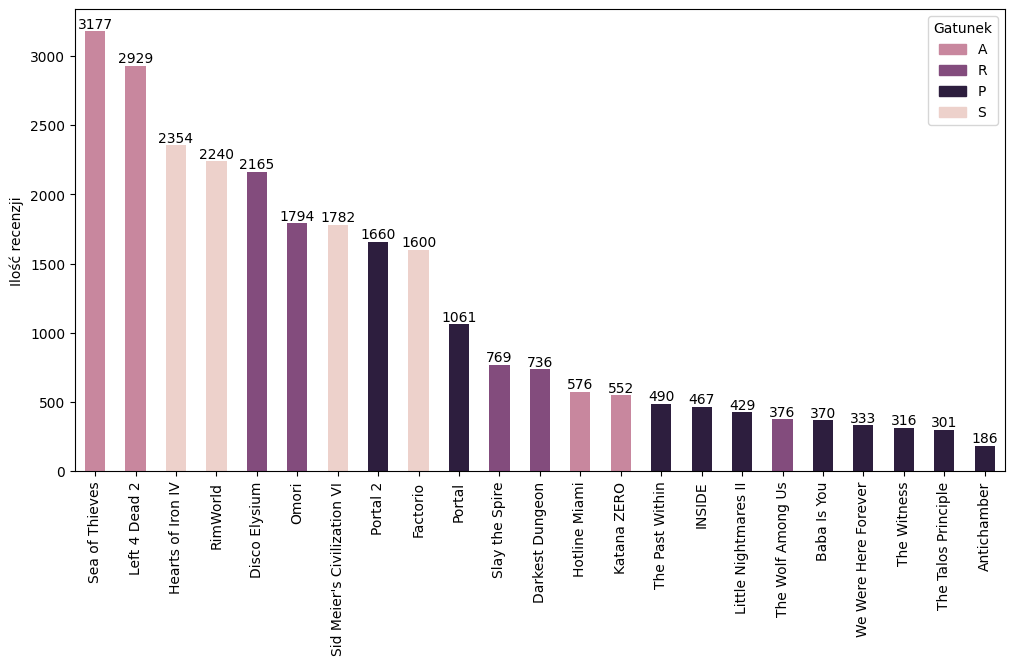

In [177]:
value_counts_title = df["title"].value_counts()
genre_colors = {"A": sns.cubehelix_palette(4)[1], "R": sns.cubehelix_palette(4)[2], "P": sns.cubehelix_palette(4)[3], 
                "S": sns.cubehelix_palette(4)[0]}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_title.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_title):
    x.text(i, count, count, va = "bottom", ha = "center")

handles = [plt.Rectangle((0,0), 1,1, color=genre_colors[label]) for label in genre_colors]
plt.legend(handles, genre_colors.keys(), title="Gatunek", loc="upper right")


plt.show()
df = df.drop(["color"], axis=1)

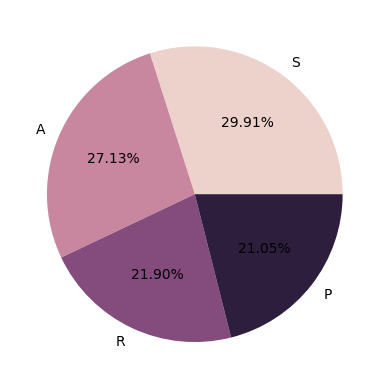

In [178]:
value_counts_genre = df["genre"].value_counts()
colors = sns.cubehelix_palette(4)
x = plt.pie(value_counts_genre, labels = value_counts_genre.index, colors=colors, autopct='%1.2f%%')
plt.show()

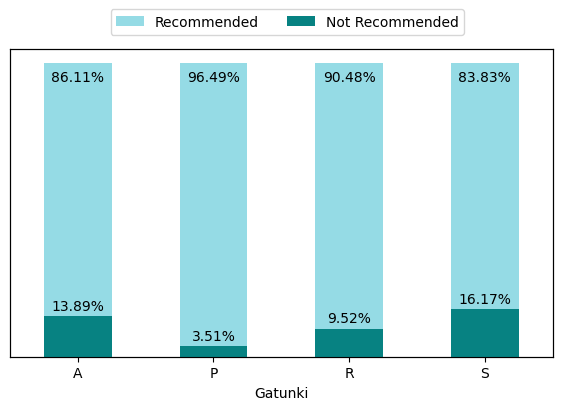

In [179]:
value_counts_recommendation_genre = df.groupby('genre').voted_up.value_counts().unstack(0)
percentage_pos = value_counts_recommendation_genre.iloc[1] / (value_counts_recommendation_genre.iloc[1] + value_counts_recommendation_genre.iloc[0]) * 100 
percentage_neg = value_counts_recommendation_genre.iloc[0] / (value_counts_recommendation_genre.iloc[0] + value_counts_recommendation_genre.iloc[1]) * 100 

total_count = percentage_pos + percentage_neg

def addlabels_neg(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] + 2, f"{x[i]:.2f}%",  ha = "center")

def addlabels_pos(x,y):
    for i in range(len(y)):
        plt.text(i, x[i] - 6, f"{y[i]:.2f}%",  ha = "center")

fig, ax1 = plt.subplots(figsize=(7, 4))
ax2 = ax1.twinx()

total_count.plot(kind="bar", color="#95DBE5FF",  label="Recommended")
percentage_neg.plot(kind="bar", color="#078282FF", label="Not Recommended")

ax1.set_xlabel("Gatunki")
ax1.tick_params(axis="y", left=False, labelleft=False)
ax2.tick_params(axis="y", right=False, labelright=False)

addlabels_neg(percentage_neg, total_count) 
addlabels_pos(total_count, percentage_pos) 

plt.legend(bbox_to_anchor=(0.85, 1.15), ncol=2)
plt.show()

## Dependency parser test

In [180]:
test = [df["final_review"][6543], df["final_review"][4534], df["final_review"][12345], df["final_review"][12354],
        df["final_review"][1925], df["final_review"][1067],df["final_review"][22951],df["final_review"][2231],
       ["not","fun", "gameplay"], df["tokenized"][832], df["final_review"][21], df["tokenized"][27061],
       df["final_review"][11088], df["final_review"][3171], df["final_review"][7834], df["final_review"][20180],
       df["final_review"][6697], df["final_review"][893]]

In [181]:
import stanza
nlp = stanza.Pipeline('en', tokenize_pretokenized=True) 
doc = nlp(test)

2024-04-19 16:21:09 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-04-19 16:21:09 INFO: Downloaded file to C:\Users\marty\stanza_resources\resources.json
2024-04-19 16:21:10 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-04-19 16:21:10 INFO: Using device: cuda
2024-04-19 16:21:10 INFO: Loading: tokenize
2024-04-19 16:21:10 INFO: Loading: mwt
2024-04-19 16:21:11 INFO: Loading: pos
2024-04-19 16:21:11 INFO: Loading: lemma
2024-04-19 16:21:11 INFO: Loading: constituency
2024-04-19 16:21:12 INFO: Loading: depparse
2024-04-19 16:21:12 INFO: Loading: sentiment
2024-04-19 16:21:13 INFO: Loading: ne

In [192]:
dependency_list = []
for dependency in doc.sentences[13].dependencies:
    dependency_list.append([dependency[2].text, dependency[0].id, dependency[1]])
    
for i in range(0, len(dependency_list)):
    if (int(dependency_list[i][1]) != 0):
        dependency_list[i][1] = test[13][(int(dependency_list[i][1]) - 1)]

print(dependency_list)

[['crewing', 0, 'root'], ['game', 'value', 'compound'], ['value', 'crewing', 'obj'], ['likely', 'crewing', 'advmod'], ['worthless', 'crewing', 'xcomp'], ['real', 'crewing', 'xcomp'], ['but', 'play', 'cc'], ['can', 'play', 'aux'], ['play', 'crewing', 'conj'], ['player', 'play', 'obj'], ['but', 'want', 'cc'], ['cant', 'want', 'aux'], ['really', 'want', 'advmod'], ['want', 'crewing', 'conj'], ['like', 'graphics', 'discourse'], ['game', 'fun', 'compound'], ['fun', 'graphics', 'amod'], ['graphics', 'want', 'obj'], ['basic', 'want', 'xcomp'], ['but', 'have', 'cc'], ['have', 'want', 'conj'], ['real', 'beauty', 'amod'], ['beauty', 'have', 'obj'], ['but', 'play', 'cc'], ['game', 'play', 'obl:npmod'], ['play', 'have', 'conj'], ['kind', 'play', 'obj'], ['rather', 'gained', 'cc'], ['but', 'gained', 'cc'], ['little', 'gained', 'nsubj:pass'], ['be', 'gained', 'aux:pass'], ['gained', 'has', 'csubj'], ['just', 'gain', 'advmod'], ['gain', 'gained', 'nsubj:pass'], ['has', 'crewing', 'conj'], ['likelihoo

In [196]:
feature_list = []
feature_opinion_list = [] 

for dependency in doc.sentences[13].dependencies:
    if dependency[2].xpos == "RB":
        opinion_word = dependency[2]
        rb_adj = dependency[0]
        
    if (dependency[2].xpos in ["NN", "NNS", "JJ", "JJS", "JJR"]) and (dependency[1] in ["amod"]):
        if dependency[0] == rb_adj or dependency[2] == rb_adj:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': opinion_word.text + " " + dependency[2].lemma}     
        else:
            if dependency[2].xpos in ["JJS", "JJR"]:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].text}
            else:
                result_dict = {'feature': dependency[0].lemma, 'opinion': dependency[2].lemma}  

        feature_list.append(dependency[0].lemma)
        feature_opinion_list.append(result_dict)

print(f'Feature list: {feature_list}')
print(f'Feature-opinion list: {feature_opinion_list}')

Feature list: ['graphic', 'beauty', 'player', 'player', 'player', 'guide', 'reward', 'reward', 'reward']
Feature-opinion list: [{'feature': 'graphic', 'opinion': 'fun'}, {'feature': 'beauty', 'opinion': 'real'}, {'feature': 'player', 'opinion': 'unbalanced'}, {'feature': 'player', 'opinion': 'janky'}, {'feature': 'player', 'opinion': 'human'}, {'feature': 'guide', 'opinion': 'necessary'}, {'feature': 'reward', 'opinion': 'risky'}, {'feature': 'reward', 'opinion': 'lowest'}, {'feature': 'reward', 'opinion': 'highest'}]


## Dependency parser final

In [197]:
with open('opinions.json', 'r') as file:
    dct = json.load(file)
    
dct

{'0': [{'feature': 'game', 'opinion': 'blind'},
  {'feature': 'game', 'opinion': 'powerful'}],
 '1': [],
 '2': [{'feature': 'gun', 'opinion': 'nekked'}],
 '4': [],
 '5': [],
 '6': [{'feature': 'chance', 'opinion': 'last'}],
 '7': [],
 '9': [],
 '10': [],
 '11': [],
 '12': [],
 '13': [{'feature': 'fear', 'opinion': 'purest'},
  {'feature': 'fear', 'opinion': 'potent'},
  {'feature': 'way', 'opinion': 'best'},
  {'feature': 'game', 'opinion': 'exactly huge'},
  {'feature': 'game', 'opinion': 'exactly childish'},
  {'feature': 'payload', 'opinion': 'emotional'},
  {'feature': 'horror', 'opinion': 'very core'},
  {'feature': 'kid', 'opinion': 'normal'},
  {'feature': 'jrpg', 'opinion': 'kiddy'},
  {'feature': 'plushie', 'opinion': 'big'},
  {'feature': 'game', 'opinion': 'general'},
  {'feature': 'way', 'opinion': 'past'},
  {'feature': 'game', 'opinion': 'very worry'},
  {'feature': 'game', 'opinion': 'rare'},
  {'feature': 'game', 'opinion': 'not fun'},
  {'feature': 'game', 'opinion': '

In [198]:
feature_list = []

for i in range(len(df)):
    index = str(i)  
    feature = dct.get(index)
    if feature is None:
        feature_list.append([])
    else:
        feature_list.append(feature)

df["feature"] = feature_list

In [199]:
df = df[df["feature"].apply(lambda x: len(x) > 0)]